## RQ3.1 Do significant differences exist in the visual features of retrieved image documents compared to those not re-trieved? 

In [16]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, pointbiserialr
from scipy.stats import pointbiserialr
from matplotlib.ticker import FuncFormatter
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, kstest, norm
from scipy.stats import norm
import scipy.stats as stats

np.random.seed(42)
def read_data(input_path):
    """Read JSONL data from a file."""
    data_entries = defaultdict(dict)
    with open(input_path, "r") as file:
        for line in file:
            data = json.loads(line)
            data_entries[data['query']] = data
    return data_entries


def process_data_with_recall(data_entries,recall_val):
    """Process data to compute various statistical metrics."""
    metrics = {
        "textual_coverages": [],
        "nontextual_coverages": [],
        "background_coverages": [],
        "total_tokens": [],
        "total": [],
        "recall_at_1": [],
        "textual_salience": []

    }

    for data in data_entries.values():
        textual_coverages = max((data['text_bbox_area'] - data['background_area_within_bboxes']) / data['total_area'],0)
        if textual_coverages < 0: 
            print(textual_coverages)
        visual_background_pixels =  (data['background_pixels'] - data['background_area_within_bboxes']) if textual_coverages != 0 else data['background_pixels']
        nontextual_coverages = (data['total_area'] - visual_background_pixels - textual_coverages) /data['total_area']
        background_coverages =  1 - nontextual_coverages - textual_coverages
        textual_salience = textual_coverages * data['total_tokens']

        metrics["textual_coverages"].append(textual_coverages)
        metrics["nontextual_coverages"].append(nontextual_coverages)
        metrics["total_tokens"].append(data['total_tokens'])
        metrics["background_coverages"].append(background_coverages)
        metrics["total"].append(data['total_area'])
        metrics["recall_at_1"].append(recall_val)
        metrics['textual_salience'].append(textual_salience)

    for key in metrics:
        metrics[key] = np.array(metrics[key])

    return pd.DataFrame(metrics)

def scientific_formatter(x, pos):
    # Normal scientific notation
    s = f"{x:.0e}"
    # Split the string into base and exponent parts
    parts = s.split('e')
    base = parts[0]
    exponent = int(parts[1])  # convert to integer to remove leading '+'

    # Define superscript mapping
    superscripts = str.maketrans("-0123456789", "⁻⁰¹²³⁴⁵⁶⁷⁸⁹")
    
    # Convert exponent to superscript
    exponent_superscript = f"e{exponent}".translate(superscripts)
    
    return f"{base}{exponent_superscript}"

def split_string_on_tokens(s):
    """Split strings into tokens."""
    return s.split()

def collect_queries(input_path, value):
    """Collect queries matching a specific recall value."""
    queries = []
    with open(input_path, "r") as infn:
        data = json.load(infn)
        for key, val in data.items():
            if val["recall_1"] == value:
                queries.append(key)
    return queries
def cliffs_delta(x, y):
    nx, ny = len(x), len(y)
    greater = sum(x_i > y_j for x_i in x for y_j in y)
    ties = sum(x_i == y_j for x_i in x for y_j in y)
    delta = (greater + 0.5 * ties) / (nx * ny) - (nx * ny - greater - 0.5 * ties) / (nx * ny)
    return delta

if __name__ == "__main__":
    datasets_name = [
        "arxivqa_test_subsampled",
        "docvqa_test_subsampled",
        "infovqa_test_subsampled",
        "tabfquad_test_subsampled",
        "tatdqa_test",
        "shiftproject_test",
        "syntheticDocQA_artificial_intelligence_test",
        "syntheticDocQA_energy_test",
        "syntheticDocQA_government_reports_test",
        "syntheticDocQA_healthcare_industry_test"
    ]
    significance = {}
    model_difference = {}
    for name in datasets_name:
        ## path of retrieved results
        paths = [
            # "outputs/bipali/_ivi_ilps_personal_jqiao_colpali_models_bipali-v1.3-PairwiseCELoss/",
            # "outputs/biqwen2/_ivi_ilps_personal_jqiao_colpali_models_biqwen2-v1.3-PairwiseCELoss/",
            # "outputs/colpali/_ivi_ilps_personal_jqiao_colpali_models_colpali-v1.3-PairwiseCELoss/",
            "outputs/colqwen2/_ivi_ilps_personal_jqiao_colpali_models_colqwen2-v1.3-PairwiseCELoss/"
        ]
        base_path = "/ivi/ilps/personal/jqiao/colpali/outputs/converage2"
        combined_df = pd.DataFrame()
        combined_df_datasets = {}

        for path in paths:
            # for name in datasets:
            input_path = f"{base_path}/{name}.jsonl"
            data_entries = read_data(input_path)

            base = "/ivi/ilps/personal/jqiao/colpali/"
            model_name = path.split("/")[1]
            if "biqwen2text" in path:
                recall_1_input_path =  base + path + f"vidore_{name}_tesseract_query_metrics.json"
            else:
                recall_1_input_path = base + path + f"vidore_{name}_query_metrics.json"

            # Process data with recall=1
            # recall_1_input_path = f"/ivi/ilps/personal/jqiao/colpali/outputs/vidore_colpali-v1.2/vidore_{name}_query_metrics.json"
            recall_1_queries = collect_queries(recall_1_input_path, 1)
            selected_recall_1_queries = {q: data_entries[q] for q in recall_1_queries if q in data_entries}
            df_recall_1 = process_data_with_recall(selected_recall_1_queries, 1)

            # Process data with recall=0
            recall_0_queries = collect_queries(recall_1_input_path, 0)
            selected_recall_0_queries = {q: data_entries[q] for q in recall_0_queries if q in data_entries}
            df_recall_0 = process_data_with_recall(selected_recall_0_queries, 0)

            # Combine the results into the main DataFrame
            combined_df = pd.concat([combined_df, df_recall_1, df_recall_0], ignore_index=True)
            combined_df_datasets[model_name] = combined_df

        for model_name, df in combined_df_datasets.items():
            grouped_stats = df.groupby('recall_at_1').agg({
                'textual_coverages': ['mean', 'median', 'std'],
                'nontextual_coverages': ['mean', 'median', 'std'],
                'background_coverages': ['mean', 'median', 'std'],
                'total_tokens': ['mean', 'median', 'std'],
                'textual_salience': ['mean', 'median', 'std']
            })
            for feat in ['textual_coverages', 'nontextual_coverages', 'background_coverages', 'total_tokens']:
                group0 = df[df['recall_at_1'] == 0]
                group1 = df[df['recall_at_1'] == 1]
                # Example data
                delta = cliffs_delta(group0[feat], group1[feat])
                u_stat, p_val_u = mannwhitneyu(group0[feat], group1[feat], alternative='less')
                corr, p_value = pointbiserialr(df['recall_at_1'], df[feat])
                spearman_correlation, p_value = stats.spearmanr(df['recall_at_1'], df[feat])
                if name not in significance:
                    significance[name] = {}
                if feat not in significance[name]:
                    significance[name][feat] ={}
                significance[name][feat] = p_val_u


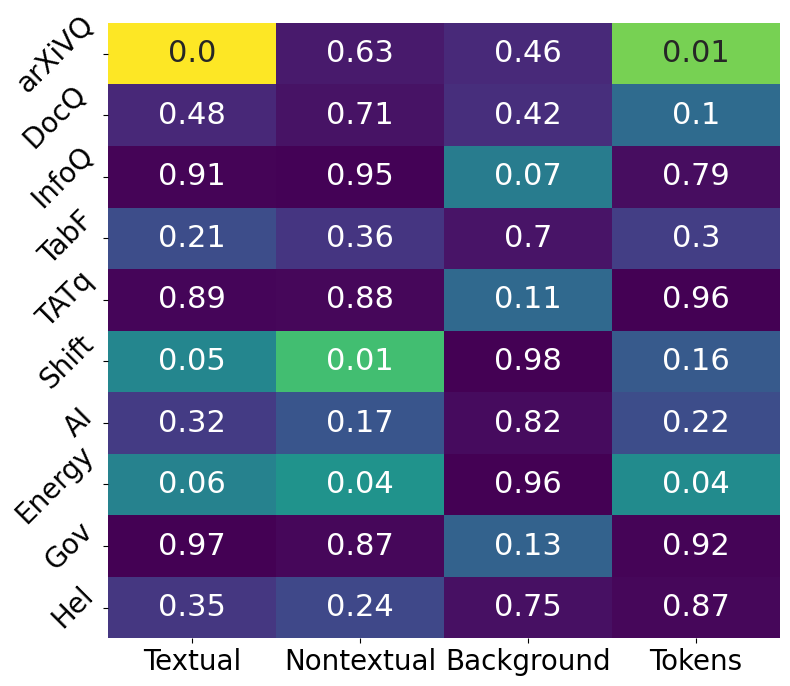

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'significance' is your existing dictionary containing p-values
sig_df = pd.DataFrame(significance).T  # Convert dictionary into DataFrame, transposing it

# Rename columns for clarity
sig_df.columns = ['Textual', 'Nontextual', 'Background', 'Tokens']

# Rename rows (index) for clarity
dataset_names = {
    'arxivqa_test_subsampled': 'arXiVQ',
    'docvqa_test_subsampled': 'DocQ ',
    'infovqa_test_subsampled': 'InfoQ',
    'tabfquad_test_subsampled': 'TabF',
    'tatdqa_test': 'TATq',
    'shiftproject_test': 'Shift',
    'syntheticDocQA_artificial_intelligence_test': 'AI',
    'syntheticDocQA_energy_test': 'Energy',
    'syntheticDocQA_government_reports_test': 'Gov',
    'syntheticDocQA_healthcare_industry_test': 'Hel',
}
sig_df.rename(index=dataset_names, inplace=True)

# Convert p-values to -log10(p-values)
sig_log = -np.log10(sig_df.replace(0, 1e-10))

# Set up the figure and the axes
plt.figure(figsize=(8, 7))
ax = sns.heatmap(sig_log, annot=sig_df.round(2), fmt='',
                 cmap='viridis', cbar_kws={'label': '-log10(p-value)'}, cbar=False)

# Set the size of the tick labels
ax.tick_params(axis='x', labelsize=20)  # Set x-tick label size
ax.tick_params(axis='y', labelsize=20, rotation=45)  # Set y-tick label size

# Set the size of the annotation text
for text in ax.texts:
    text.set_size(22)

plt.tight_layout()
plt.savefig(f"/ivi/ilps/personal/jqiao/colpali/plots/confusion_{model_name}.pdf")
plt.show()
